# Seasonality

Loading data from matlab struct, reformatted in matlab from matlab table and then looking at the seasonality of the WIM data at Ceneri. The years 2011-2019 were looked at and then due to gaps in data only 2014 was used to look at daily/hourly seasonality.

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
stations = ['Ceneri', 'Denges', 'Gotthard']

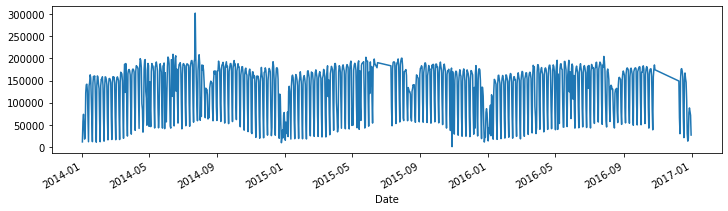

In [20]:
df_day.plot(figsize=(12,3))

Given the large gaps in data in 2015 and 2017, while there seems to be seasonal behavior on the yearly level, let's look specifically at 2014.

In [21]:
df_2014 = df_day.loc['2014-01-01':'2014-12-31']

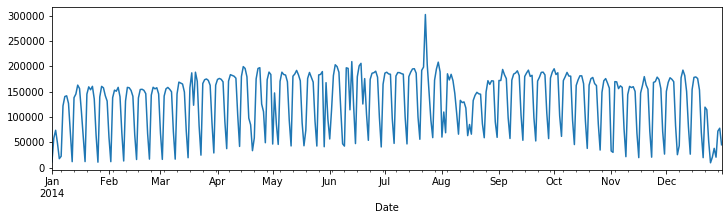

In [22]:
df_2014.plot(figsize=(12,3))

Below shows the weekly seasonality.

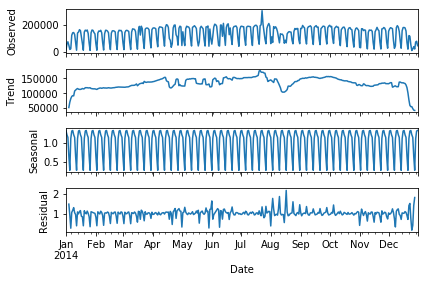

In [23]:
result = seasonal_decompose(df_2014, model='multiplicative')
result.plot()
pyplot.show()

Now we want to look at seasonality when the hour is incorporated.

Below shows the 2014 seasonality by day. First it is necessary to remove any holidays or sundays. Sundays can easily be removed with the datetime and the holidays are taking from a list of Ticino holidays.

In [26]:
holidays = ['2014-01-01', '2014-01-06', '2014-03-19', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09', '2014-06-19', 
            '2014-06-29', '2014-08-01', '2014-08-15', '2014-11-01', '2014-12-07', '2014-12-25', '2014-12-26']

In [33]:
df_2014_hour.shape

(8755,)

In [35]:
df_2014_weekdays = df_2014_hour.loc[~(df_2014_hour.index.floor('D').isin(holidays))]

In [37]:
df_2014_weekdays = df_2014_weekdays[df_2014_weekdays.index.weekday!=(5 or 6)]

In [38]:
df_2014_weekdays.shape

(7171,)

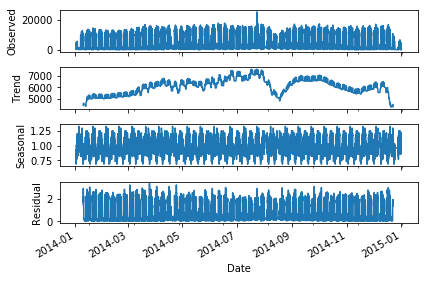

In [39]:
result = seasonal_decompose(df_2014_weekdays, model='multiplicative', freq=300)
result.plot()
pyplot.show()

Looking at a single month, March

In [43]:
df_2014_week = df_2014_weekdays.loc['2014-03-24 00:00:00':'2014-03-28 23:00:00']

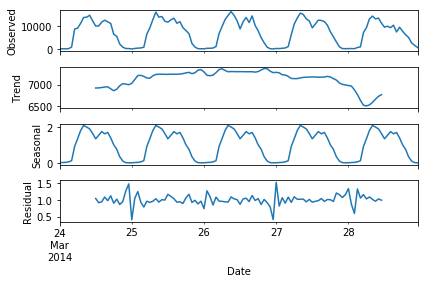

In [45]:
result = seasonal_decompose(df_2014_week, model='multiplicative')
result.plot()
pyplot.show()

### Truck Weight Seasonality

This section will explore if there is any seasonality with the truck weight/number of trucks within a given time span.

In [162]:
years.index = years.index.year

In [163]:
years.index.name = "Year"

In [164]:
df_count_year.index.names = ['Year', 'Hour']
df_count_year

Year  Hour
2011  0        6136
      1        6712
      2        6096
      3        6814
      4       10439
              ...  
2019  19      43573
      20      28327
      21      16726
      22      10515
      23       7845
Name: Date, Length: 216, dtype: int64

In [172]:
df_count['Year'] = df.Date.dt.year

In [173]:
df_merged = pd.merge(years.rename('total_days'), pd.DataFrame(df_count), on="Year", how="right")

In [174]:
df_merged.head()

,Year,total_days,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,2011.0,365.0,4,3.50,0,408,674,5,2011-01-01 00:54:14
1,2011.0,365.0,4,5.27,0,408,839,8,2011-01-01 00:54:48
2,2011.0,365.0,4,19.28,12,408,1429,10,2011-01-01 02:43:02
3,2011.0,365.0,4,4.40,0,408,742,5,2011-01-01 02:54:33
4,2011.0,365.0,4,4.09,0,408,819,8,2011-01-01 03:12:30


In [179]:
df_merged['Date_d'] = df_merged.Date.dt.date

In [181]:
df_merged = df_merged.groupby([times.dt.year, times.dt.hour]).agg({'Date':'count', 'Date_d':'nunique'}) 

In [184]:
df_merged.head()

Date  Date_d  norm_count
Date Date                           
2011 0      6136     365   16.810959
     1      6712     365   18.389041
     2      6096     364   16.747253
     3      6814     365   18.668493
     4     10439     365   28.600000

In [183]:
df_merged['norm_count'] = df_merged.Date/df_merged.Date_d

In [166]:
df_merged = pd.merge(years.rename('total_days'), pd.DataFrame(df_count_year), on="Year", how="right")

In [167]:
df_merged['Count_norm'] = df_merged['Date']/df_merged['total_days']

In [169]:
df_merged.Count_norm

Year
2011     16.810959
2011     18.389041
2011     16.701370
2011     18.668493
2011     28.600000
           ...    
2019    140.558065
2019     91.377419
2019     53.954839
2019     33.919355
2019     25.306452
Name: Count_norm, Length: 216, dtype: float64

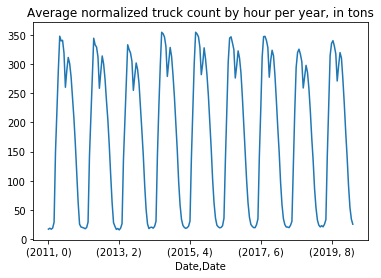

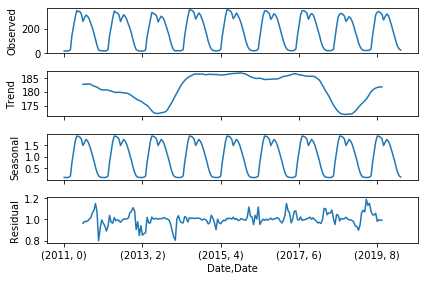

In [185]:
df_merged.norm_count.plot(title="Average normalized truck count by hour per year")
result = seasonal_decompose(df_merged.norm_count, model='multiplicative', freq=24)
result.plot()
pyplot.show()

In [194]:
df_yearly_count = df_count.groupby([times.dt.year]).Date.count()
df_year_nrom = df_yearly_cunt/years

(0, 5000)

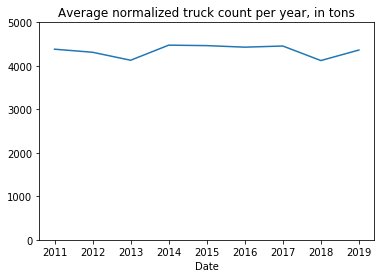

In [197]:
ax =df_year_nrom.plot(title="Average normalized truck count per year, in tons")
ax.set_ylim(0, 5000)

In [51]:
def weight_seasonality(station, seasonality):

    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        model = 'additive'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'DoY'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
        model = 'additive'
    
    #Get the general truck data
    df_truck = pd.read_pickle('{}Data/2011_2019_datetime.pkl'.format(station))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    
    #Remove saturday and sunday
    #df_truck = df_truck[~df_truck.Weekday.isin([5, 6])]
    
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['GW_TOT'] = df_truck['GW_TOT']/1000
    
    if seasonality == 'Daily':
        df_truck_hour = df_truck.groupby([truck_count,precision]).GW_TOT.mean()
        
    elif seasonality == 'Weekly':
        df_truck['Day of year'] = df_truck.Date.dt.dayofyear
        df_truck_hour = df_truck.groupby('Day of year').GW_TOT.mean()
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_truck_hour = df_truck_hour.reset_index(1)
        df_truck_hour = df_truck_hour.drop(columns='Hour')
        df_truck_hour = df_truck_hour.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})        
        
    #Plotting
    #df_truck_hour.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
    result = seasonal_decompose(df_truck_hour, model=model, freq=frequency)
    fig = result.plot()
    fig.suptitle('{} {} Weight Decomposition'.format(station, seasonality), y=1.03)
        
    fig.savefig('Figures/{}/{}_weight_season.png'.format(station, seasonality), bbox_inches='tight')
    
    plt.show()    

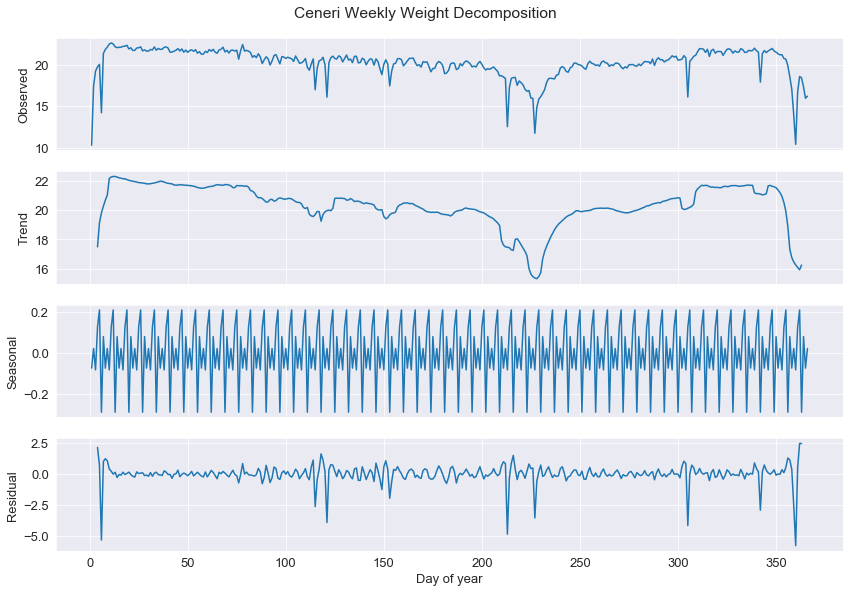

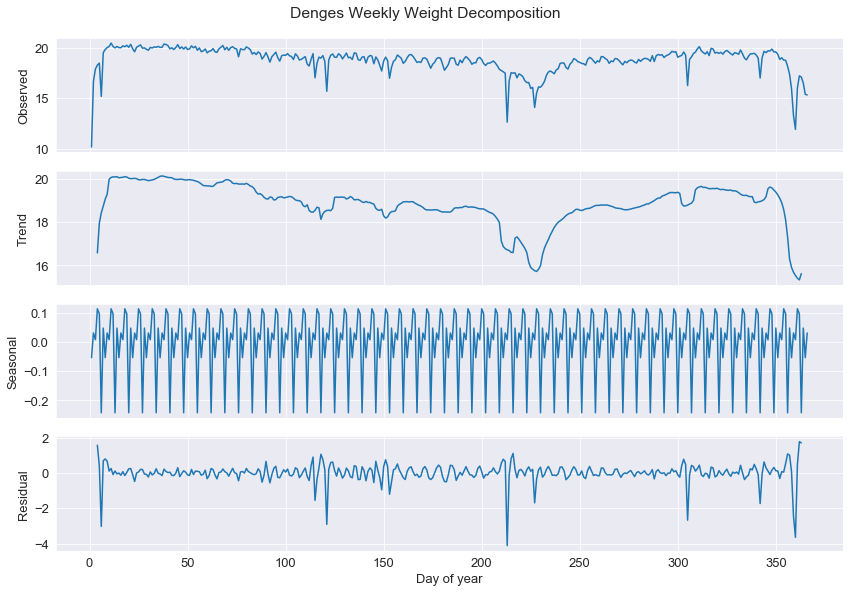

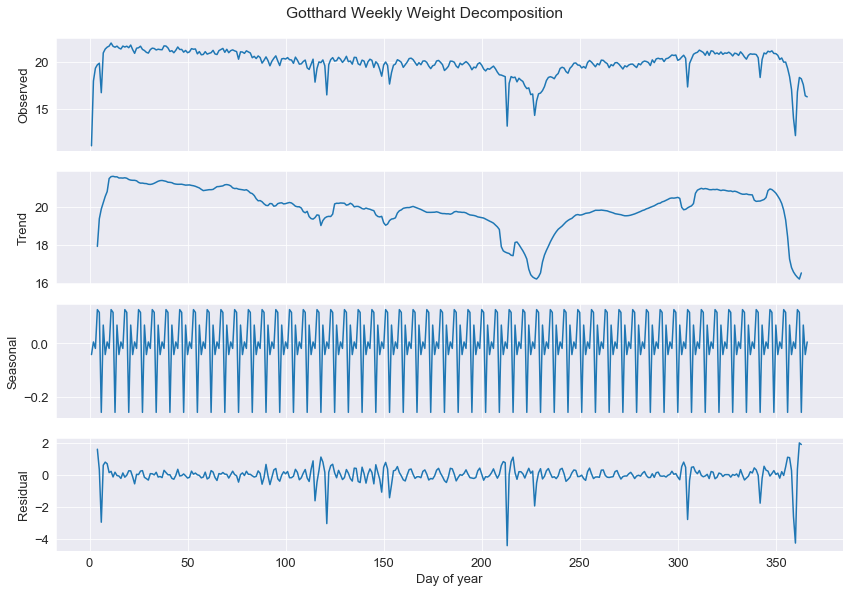

In [52]:
for station in stations:
    #weight_seasonality(station, 'Daily')
    weight_seasonality(station, 'Weekly')

## Platoon Seasonality

This section will take the platoons found in the PlatoonFinding folder and plot the beginning time of the platoon, grouping by hour and day of the week.

In [8]:
def platoon_seasonality(station, seasonality, minute, pickle):
    
    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'Day of year'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
    
    #Get the platoon data
    df_platoon = pd.read_pickle('{}Data/2011_2019_platoon.pkl'.format(station))
    df_platoon = df_platoon[df_platoon.Length > 1] #Only keep platoons that are at least of length 2
    df_platoon['Weekday'] = df_platoon.Start.dt.weekday
    df_platoon['Hour'] = df_platoon.Start.dt.hour
    df_platoon['Date_d'] = df_platoon.Start.dt.date
    df_platoon['Day of year'] = df_platoon.Start.dt.dayofyear
    df_platoon['Year'] = df_platoon.Start.dt.year

    
    #Get the general truck data for normalization
    df_truck = pd.read_pickle('{}Data/2011_2019_datetime.pkl'.format(station))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['Day of year'] = df_truck.Date.dt.dayofyear
    df_truck['Year'] = df_truck.Date.dt.year

    if seasonality == 'Weekly':
        df_platoon_hour = df_platoon.groupby([truck_count]).Start.count().reset_index().rename(columns={'Start':'count'})
    
    elif seasonality == 'Daily':
        if minute:
            df_platoon['Minute'] = df_platoon.Start.dt.minute
            df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
        else:
            df_platoon_hour = df_platoon.groupby([truck_count,precision]).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour

    df_truck_date = df_truck.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
    df_platoon_grouped = df_truck_date.merge(df_platoon_hour, on=truck_count)
    df_platoon_grouped = df_platoon_grouped.set_index(truck_count)
    
    #Normalizing
    df_platoon_grouped['norm_count'] = df_platoon_grouped['count']/df_platoon_grouped['seasonal_count']
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_platoon_grouped = df_platoon_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})
    
    if pickle:
        df_platoon_grouped.to_pickle('{}Data/platoon_{}_seasonality.pkl'.format(station, seasonality))
    else:
        #Plotting
        #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
        result = seasonal_decompose(df_platoon_grouped.norm_count, model='additive', freq=frequency)
        fig = result.plot()

        fig.suptitle('{} {} Platoon Decomposition'.format(station, seasonality), y=1.03)

        fig.savefig('Figures/{}/{}_platoon_season.png'.format(station, seasonality), bbox_inches='tight')

        plt.show()

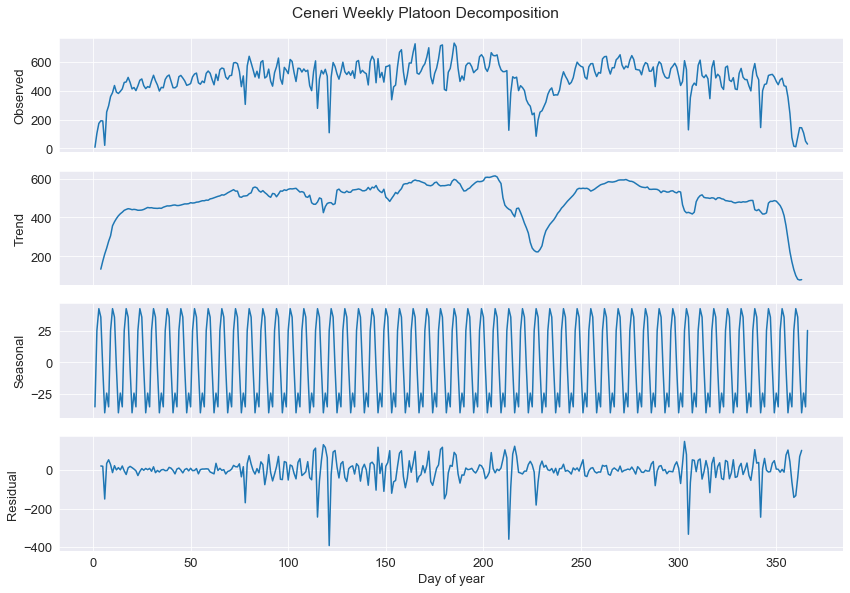

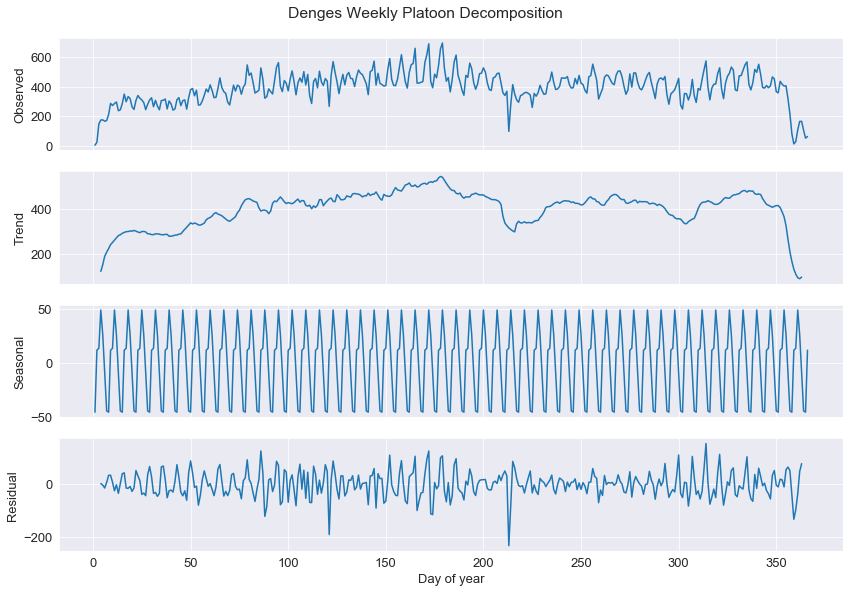

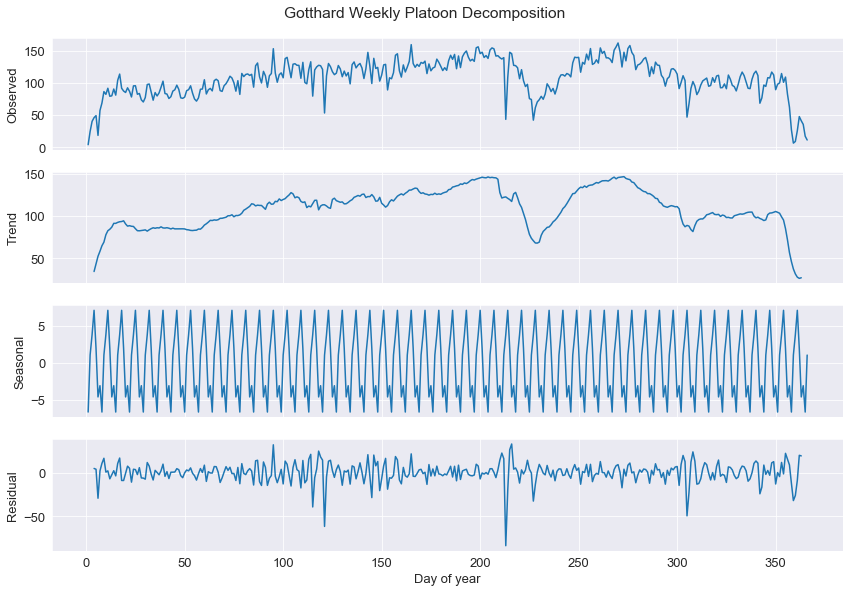

In [56]:
for station in stations:
    platoon_seasonality(station, 'Weekly')

In [9]:
for station in stations:
    platoon_seasonality(station, 'Daily', True, True)

### Correlation

This section aims to investigate the correlation between features to see which features are correlated together, particularly with time.

In [94]:
df = pd.read_csv('{}Data/2011_2018_datetime.csv'.format(Station), index_col=0, parse_dates=['Date']) 

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [95]:
df.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,4,3500,0,408,674,5,2011-01-01 00:54:14
1,4,5270,0,408,839,8,2011-01-01 00:54:48
2,4,19280,12,408,1429,10,2011-01-01 02:43:02
3,4,4400,0,408,742,5,2011-01-01 02:54:33
4,4,4090,0,408,819,8,2011-01-01 03:12:30


In [97]:
df['weekday'] = df.Date.dt.weekday

In [99]:
df['hour'] = df.Date.dt.hour

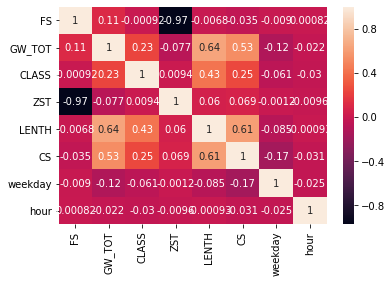

In [100]:
import matplotlib.pyplot as plt
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()